In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd

/tmp/ipykernel_6375/3408467763.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
datasets = ['face', 'osm']
colors = ['red', 'orange', 'green', 'blue', 'purple', 'gray']

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [4]:
def thousands_formatter(x, pos):
    return '%1.0fk' % (x * 1e-3) if x >= 1000 else str(int(x))

formatter = FuncFormatter(thousands_formatter)

In [5]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

df_combined = pd.DataFrame()

for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    depth_counts = df['depth'].value_counts(normalize=True).sort_index().rename_axis('depth').reset_index(name=f'proportion_{i}')
    depth_counts[f'proportion_{i}'] *= 100 
    df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer') if not df_combined.empty else depth_counts

df_combined.fillna(0, inplace=True)

plt.figure(figsize=(10, 6))
bar_width = 0.50
indices = np.arange(len(datasets))  

bottom_proportion = np.zeros(len(datasets))  

for i in df_combined['depth']:
    proportions = df_combined[[f'proportion_{j}' for j in range(len(datasets))]].loc[df_combined['depth'] == i].values.flatten()
    plt.bar(indices, proportions, width=bar_width, bottom=bottom_proportion, label=f'Depth {i}', color=colors[i])
    bottom_proportion += proportions

ymax = plt.ylim()[1]
plt.ylim(0, ymax * 1.1)

plt.ylabel('Proportion of Node Count (%)', fontweight='bold')
plt.title('Proportion of Node Count by Workload (Relative Value)', fontweight='bold')
plt.xticks(indices, datasets, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Node Depth')
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    depth_counts = df['depth'].value_counts(normalize=False).sort_index().rename_axis('depth').reset_index(name=f'count_{i}')
    df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer') if not df_combined.empty else depth_counts

df_combined.fillna(0, inplace=True)

bar_width = 0.3  
indices = np.arange(len(datasets))  

bottom_count = np.zeros(len(datasets))

for i in df_combined['depth']:
    counts = df_combined[[f'count_{j}' for j in range(len(datasets))]].loc[df_combined['depth'] == i].values.flatten()
    plt.bar(indices, counts, width=bar_width, bottom=bottom_count, label=f'{i}', color=colors[i])
    bottom_count += counts

ymax = plt.ylim()[1]
plt.ylim(0, ymax * 1.1)

plt.title('# of Node per Depth after Bulk Loading', fontweight='bold', fontsize=12)
plt.xticks(indices, datasets, fontsize=12)
plt.xlabel('Dataset', fontweight='bold', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('# of Node', fontweight='bold', fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Depth')
plt.show()

KeyError: 'depth'

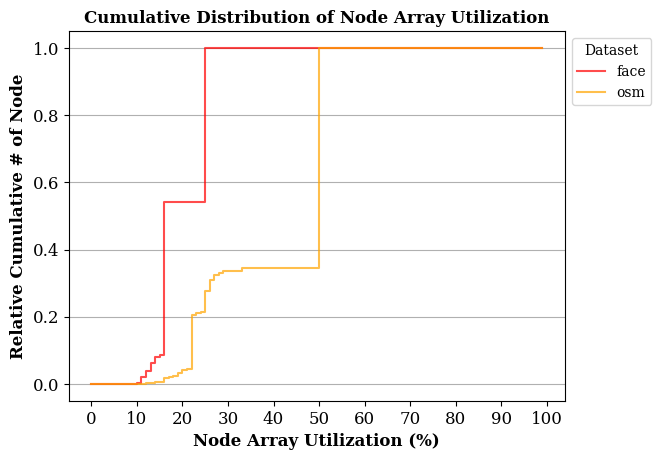

In [5]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

plt.figure()

for i, file_name in enumerate(csv_file_names):
    try:
      df = pd.read_csv(file_name, header=None)
    except Exception as e:
      continue

    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)

    plt.plot(percent_intervals[:-1], cumulative_counts,
             drawstyle='steps-post', color=colors[i % len(colors)], alpha=0.7, label=file_name.split('/')[-1].split('.')[0])

plt.title('Cumulative Distribution of Node Array Utilization', fontweight='bold', fontsize=12)
plt.xlabel('Node Array Utilization (%)', fontweight='bold', fontsize=12)
plt.ylabel('Relative Cumulative # of Node', fontweight='bold', fontsize=12)
plt.xticks(np.arange(0, 101, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')
plt.show()

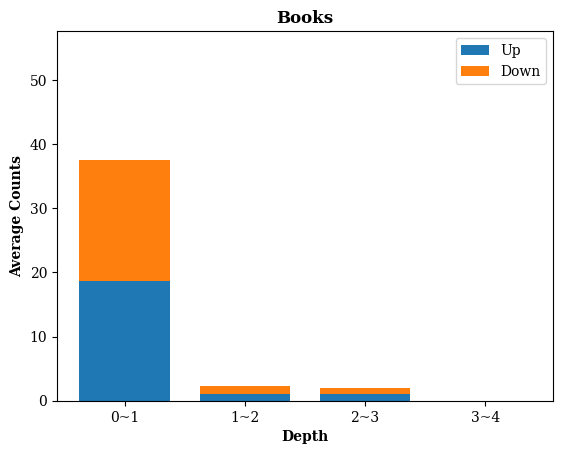

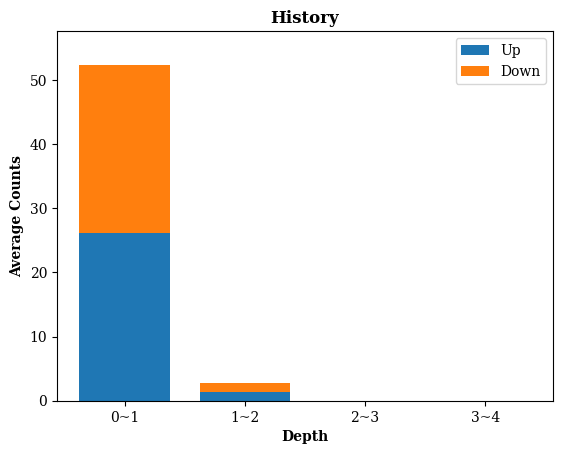

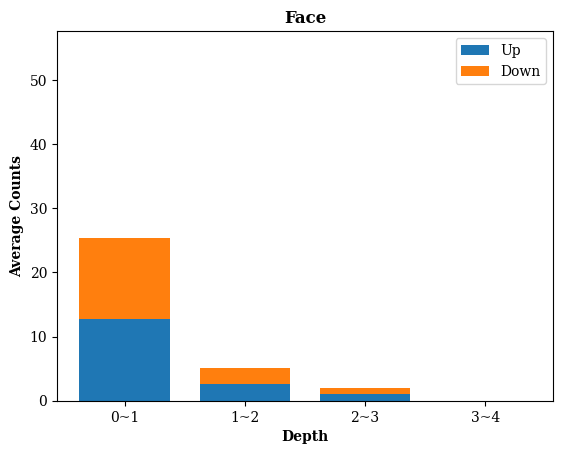

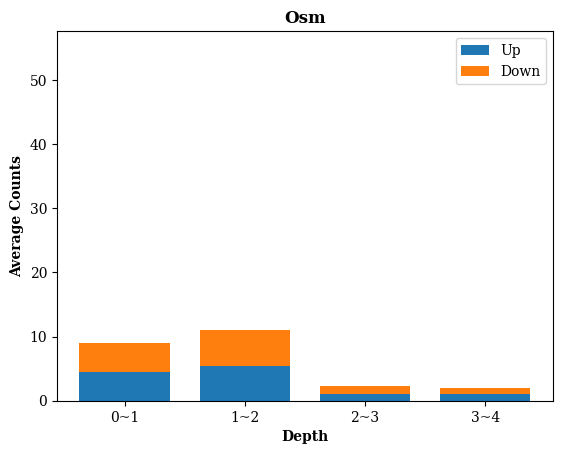

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

all_depths = set()

for file_name in csv_file_names:
    df = pd.read_csv(file_name)
    for depth, _, _ in df.itertuples(index=False):
        try:
            all_depths.add(int(depth))
        except ValueError:
            continue

all_depths = sorted(all_depths)

averages = np.arange(len(csv_file_names), dtype=object)
global_ups_downs = []

for i, file_name in enumerate(csv_file_names):
    depth_data = {}
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            depth = int(depth)
        except ValueError:
            continue
            
        if depth not in depth_data:
            depth_data[depth] = {'up': [], 'down': []}
        depth_data[depth]['up'].append(up)
        depth_data[depth]['down'].append(down)

    averages[i] = {depth: {'up': np.mean(info['up']), 'down': np.mean(info['down'])} for depth in all_depths for info in [depth_data.get(depth, {'up': [0], 'down': [0]})]}
    global_ups_downs.extend([averages[i][depth]['up'] + averages[i][depth]['down'] for depth in all_depths])

y_min = min(global_ups_downs)
y_max = max(global_ups_downs)

for i, file_name in enumerate(csv_file_names):
    ups = [averages[i][depth]['up'] for depth in all_depths]
    downs = [averages[i][depth]['down'] for depth in all_depths]

    fig, ax = plt.subplots()
    bar_width = 0.3
    index = np.arange(len(all_depths)) * (bar_width + 0.1)
    xlabels = [f'{int(depth)}~{int(depth) + 1}' for depth in all_depths]

    ax.bar(index, ups, bar_width, label='Up')
    ax.bar(index, downs, bar_width, bottom=ups, label='Down')

    ax.set_xlabel('Depth', fontweight='bold')
    ax.set_ylabel('Average Counts', fontweight='bold')
    ax.set_title(datasets[i][:1].upper() + datasets[i][1:], fontweight='bold')
    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_ylim([y_min, y_max * 1.1])
    ax.legend(loc='upper right')

    plt.show()

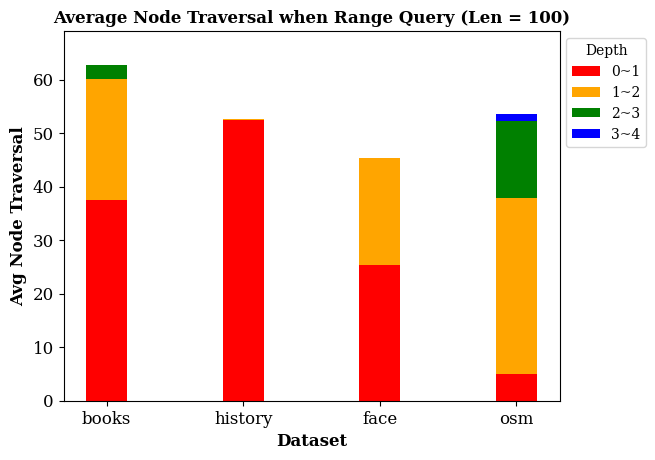

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

depth_totals = {}

def read_and_group_csv(file_name):
    df = pd.read_csv(file_name)
    grouped_data = []
    current_group = []
    for _, row in df.iterrows():
        if row['depth'] == '--------------------------':
            if current_group:
                grouped_data.append(pd.DataFrame(current_group, columns=['depth', 'up', 'down']))
                current_group = []
        else:
            current_group.append(row)
    if current_group:
        grouped_data.append(pd.DataFrame(current_group, columns=['depth', 'up', 'down']))
    return grouped_data

for dataset, file_name in zip(datasets, csv_file_names):
    grouped_data = read_and_group_csv(file_name)
    group_count = len(grouped_data)
    depth_totals[dataset] = {}
    
    for group in grouped_data:
        for _, row in group.iterrows():
            try:
                depth = int(row['depth'])
            except ValueError:
                continue
            
            total = row['up'] + row['down']
            
            if depth in depth_totals[dataset]:
                depth_totals[dataset][depth] += total
            else:
                depth_totals[dataset][depth] = total

dataset_avgs = {dataset: {depth: np.mean(totals) for depth, totals in depths.items()} for dataset, depths in depth_totals.items()}
all_depths = sorted({depth for depths in depth_totals.values() for depth in depths.keys()})

fig, ax = plt.subplots()
index = np.arange(len(datasets))
bar_width = 0.3
bottoms = np.zeros(len(datasets))

for depth in all_depths:
    avgs = [dataset_avgs[dataset].get(depth, 0) / group_count for dataset in datasets]
    ax.bar(index, avgs, bar_width, bottom=bottoms, color=colors[all_depths.index(depth) % len(colors)], label=f'{depth}~{int(depth) + 1}')
    bottoms += np.array(avgs)

y_max = max(bottoms)

ax.set_title('Average Node Traversal when Range Query (Len = 100)', fontweight='bold')
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_xticks(index)
ax.set_xticklabels(datasets)
ax.set_ylabel('Avg Node Traversal', fontweight='bold', fontsize=12)
ax.set_ylim([0, y_max * 1.1])
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Depth')

# plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

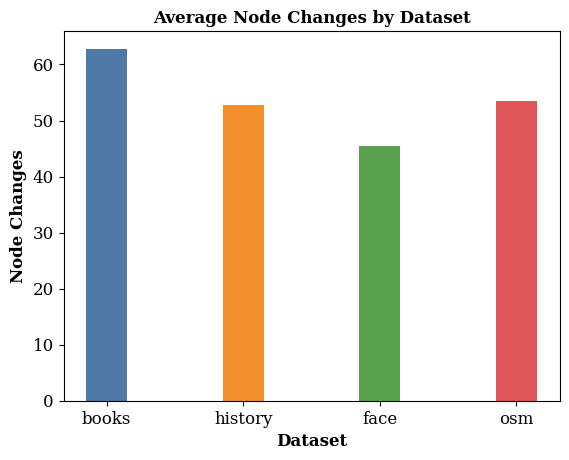

In [ ]:
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']
averages = []

for i, file_name in enumerate(csv_file_names):
    idx = 0
    data = []
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            int(depth)
            if len(data) <= idx:
                data.append(up + down)
            else:
                data[idx] += up + down
        except ValueError:
            idx += 1
    
    avg = np.mean(data) if data else float('nan')
    averages.append(avg)

fig, ax = plt.subplots()

for i, dataset in enumerate(datasets):
    ax.bar(dataset, averages[i], 0.3, color=colors[i])

ax.set_title('Average Node Changes by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_ylabel('Node Changes', fontweight='bold', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.show()

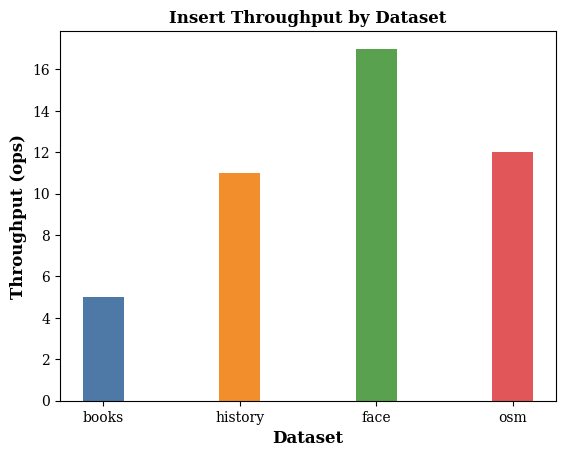

In [ ]:
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']

file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

throughput_means = df.groupby('key_path', sort=False)['throughput'].mean()

latency_percentiles = ["50 percentile", "90 percentile", "99 percentile", "99.9 percentile", "99.99 percentile"]

latencies = df.set_index('key_path')[latency_percentiles].T

fig, ax = plt.subplots()

xticks = [index.split('/')[-1] for index in throughput_means.index]

for i, dataset in enumerate(datasets):
    ax.bar(xticks[i], throughput_means.values[i], 0.3, color=colors[i])
    
ax.set_title('Insert Throughput by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_ylabel('Throughput (ops)', fontweight='bold', fontsize=12)
ax.yaxis.set_major_formatter(formatter)


/tmp/ipykernel_1548078/3650866155.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


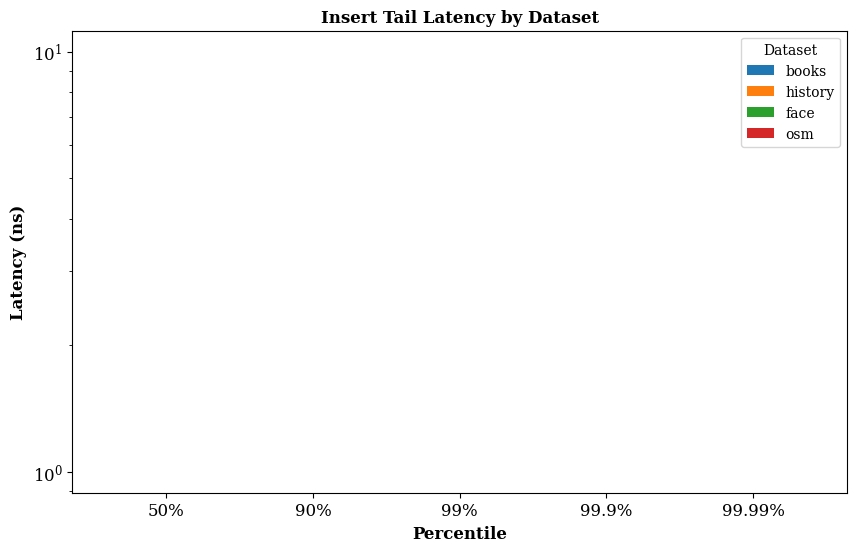

In [ ]:
file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

latency_percentiles = ['50 percentile', '90 percentile', '99 percentile', '99.9 percentile', '99.99 percentile']
xlabels = ['50%', '90%', '99%', '99.9%', '99.99%']

datasets = df['key_path'].unique()
n_datasets = len(datasets)
n_percentiles = len(latency_percentiles)

group_width = 0.8
bar_width = group_width / n_datasets
indices = np.arange(n_percentiles)

fig, ax = plt.subplots(figsize=(10, 6))

for i, dataset in enumerate(datasets):
    latencies = df[df['key_path'] == dataset][latency_percentiles].mean()
    offsets = indices - group_width / 2 + i * bar_width + bar_width / 2
    label = dataset.split('/')[-1]
    ax.bar(offsets, latencies, bar_width, label=label)

ax.set_title('Insert Tail Latency by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Percentile', fontweight='bold', fontsize=12)
ax.set_ylabel('Latency (ns)', fontweight='bold', fontsize=12)
ax.set_xticks(indices)
ax.set_xticklabels(xlabels)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=12)
ax.legend(title='Dataset')

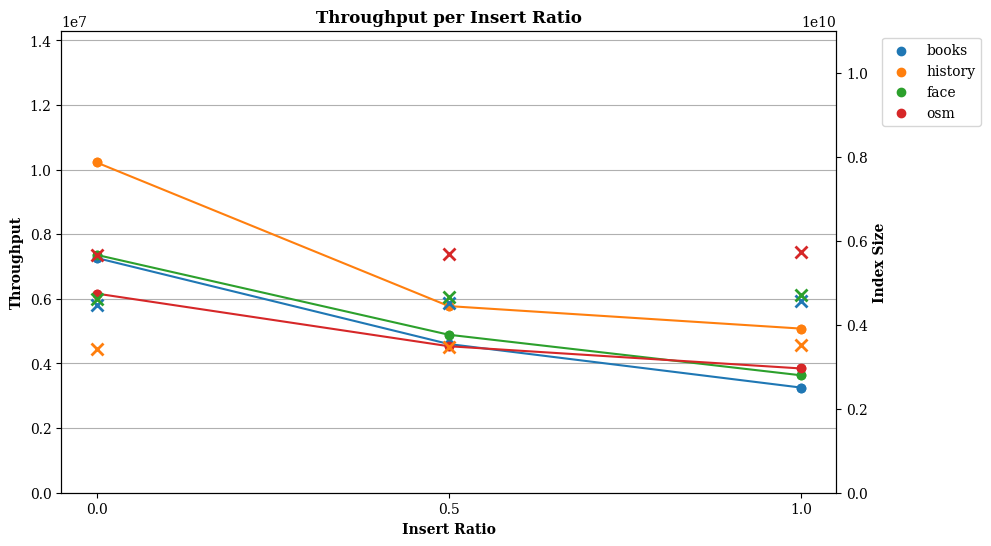

In [46]:
file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

xticks = set(df['insert_ratio'])
ymax = 1.3 * 1e7

plt.figure(figsize=(10, 6))

for key_path in df['key_path'].unique():
    subset = df[df['key_path'] == key_path]
    label = key_path.split('/')[-1]
    plt.scatter(subset['insert_ratio'], subset['throughput'], label=label)
    plt.plot(subset.sort_values('insert_ratio')['insert_ratio'], subset.sort_values('insert_ratio')['throughput'], marker='o', linestyle='-')

plt.title('Throughput per Insert Ratio', fontweight='bold')
plt.xlabel('Insert Ratio', fontweight='bold')
plt.ylabel('Throughput', fontweight='bold')
plt.xticks(list(xticks))
plt.ylim(0, ymax * 1.1)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')

ymax = 10 * 1e9

ax2 = plt.twinx()
for key_path in df['key_path'].unique():
    subset = df[df['key_path'] == key_path].sort_values('insert_ratio')
    ax2.plot(subset['insert_ratio'], subset['memory_consumption'], 'x', markersize=8, markeredgewidth=2)

ax2.set_ylabel('Index Size', fontweight='bold')
ax2.set_ylim(0, ymax * 1.1)

plt.show()